In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from keras.utils import plot_model

Run subject_segregation.py and check-subject-validity.py prior to this.

In [32]:
#Create uun list for testing, training and validation

random.seed(100)
src_folder = '../processed-data/'

uun_list = [s for s in os.listdir(src_folder) if s[0]== 's']
uun_list = random.sample(uun_list,len(uun_list))

training_list = uun_list[0:63] 
testing_list = uun_list[63:71]
validation_list = uun_list[71:]

print("Total size of list: " + str(len(uun_list)))
print("Total size of training list: " + str(len(training_list)))
print("Total size of testing list: " + str(len(testing_list)))
print("Total size of validation list: " + str(len(validation_list)))
if (len(uun_list) == (len(training_list) + len(testing_list) + len(validation_list))):
    print("List indexed correctly.")
else:
    print("List indexed incorrectly. Please check the input source again.")

Total size of list: 78
Total size of training list: 63
Total size of testing list: 8
Total size of validation list: 7
List indexed correctly.


In [33]:
def create_dataFrame(uun_list, df_name, src_folder):
    base_df = pd.DataFrame()
    
    for uun in uun_list:
        files_per_uun = [s for s in os.listdir(os.path.join(src_folder,uun))]
        
        for file in files_per_uun:
            # load data into a DataFrame 
            path = os.path.join(src_folder, uun, file)
            new_df = pd.read_csv(path)
            # merge into the base DataFrame 
            base_df = pd.concat([base_df, new_df])
            
    base_df.reset_index(drop=True, inplace=True)
    base_df.drop(base_df[base_df['sensor_type'] == "Thingy"].index, inplace = True)
    
    print(f"Data from: {df_name}")
    print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
    print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
    print(f"The number of activities collected: {len(base_df.activity_type.unique())}")
    print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
    print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")
    print("\n")
            
    return base_df

def clean_dataFrame(df):
    df.drop('notes', axis=1, inplace=True)
    df.drop('sensor_type', axis=1, inplace=True)
    df.drop('subject_id', axis=1, inplace=True)
    df.drop('activity_code', axis=1, inplace=True)
    df.dropna(inplace=True)
    
def get_sliding_windows(df):
    recording_id_list = df.recording_id.unique()
    sliding_windows = pd.DataFrame()
    window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
    step_size = 25 # this is 50% overlap

    window_number = 0 # start a counter at 0 to keep track of the window number

    for recording in recording_id_list:
        current_window = df.loc[df['recording_id'] == recording]
        large_enough_windows = [window for window in current_window.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
        overlapping_windows = large_enough_windows[::step_size] 

        for window in overlapping_windows:
            window.loc[:, 'window_id'] = window_number
            window_number += 1

        final_sliding_windows = pd.concat(overlapping_windows)
        sliding_windows = pd.concat([sliding_windows, final_sliding_windows])

    sliding_windows.reset_index(drop=True, inplace=True)
    return sliding_windows

def model_data(df_sliding_windows):
    X = []
    y = []

    for window_id, group in df_sliding_windows.groupby('window_id'):
        print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        print(f"shape = {shape}")
        
        X.append(group[columns_of_interest].values)
        y.append(class_labels[group["activity_type"].values[0]])
        
    X = np.asarray(X)
    y = np.asarray(pd.get_dummies(np.asarray(y)), dtype=np.float32)
    return (X,y)

In [34]:
training_df = create_dataFrame(training_list, "Training DF", src_folder)
testing_df = create_dataFrame(testing_list, "Testing DF", src_folder)
validation_df = create_dataFrame(validation_list, "Validation DF", src_folder)

Data from: Training DF
The data was collected using the sensors: ['Respeck']
The data was collected for the activities: ['Walking at normal speed' 'Descending stairs' 'Lying down on back'
 'Sitting bent backward' 'Lying down right' 'Movement'
 'Sitting bent forward' 'Climbing stairs' 'Standing' 'Desk work' 'Sitting'
 'Lying down left' 'Lying down on stomach' 'Running']
The number of activities collected: 14
The number of unique recordings is: 882
The subject IDs in the recordings are: 64


Data from: Testing DF
The data was collected using the sensors: ['Respeck']
The data was collected for the activities: ['Climbing stairs' 'Sitting bent backward' 'Lying down left'
 'Walking at normal speed' 'Lying down on back' 'Movement'
 'Lying down on stomach' 'Running' 'Lying down right'
 'Sitting bent forward' 'Desk work' 'Sitting' 'Descending stairs'
 'Standing']
The number of activities collected: 14
The number of unique recordings is: 112
The subject IDs in the recordings are: 8


Data from: 

In [35]:
clean_dataFrame(training_df)
clean_dataFrame(testing_df)
clean_dataFrame(validation_df)

In [36]:
training_df.drop(training_df[training_df['activity_type'] == "Climbing stairs"].index, inplace = True)
training_df.drop(training_df[training_df['activity_type'] == "Descending stairs"].index, inplace = True)
training_df.drop(training_df[training_df['activity_type'] == "Movement"].index, inplace = True)

testing_df.drop(testing_df[testing_df['activity_type'] == "Climbing stairs"].index, inplace = True)
testing_df.drop(testing_df[testing_df['activity_type'] == "Descending stairs"].index, inplace = True)
testing_df.drop(testing_df[testing_df['activity_type'] == "Movement"].index, inplace = True)

validation_df.drop(validation_df[validation_df['activity_type'] == "Climbing stairs"].index, inplace = True)
validation_df.drop(validation_df[validation_df['activity_type'] == "Descending stairs"].index, inplace = True)
validation_df.drop(validation_df[validation_df['activity_type'] == "Movement"].index, inplace = True)


training_df['activity_type'] = training_df['activity_type'].replace(['Sitting', 'Sitting bent forward', 'Sitting bent backward', 'Standing', 'Desk work'], 'Sitting/Standing')
testing_df['activity_type'] = testing_df['activity_type'].replace(['Sitting', 'Sitting bent forward', 'Sitting bent backward', 'Standing', 'Desk work'], 'Sitting/Standing')
validation_df['activity_type'] = validation_df['activity_type'].replace(['Sitting', 'Sitting bent forward', 'Sitting bent backward', 'Standing', 'Desk work'], 'Sitting/Standing')

training_df['activity_type'] = training_df['activity_type'].replace(['Lying down right', 'Lying down left', 'Lying down on back', 'Lying down on stomach'], 'Lying down')
testing_df['activity_type'] = testing_df['activity_type'].replace(['Lying down right', 'Lying down left', 'Lying down on back', 'Lying down on stomach'], 'Lying down')
validation_df['activity_type'] = validation_df['activity_type'].replace(['Lying down right', 'Lying down left', 'Lying down on back', 'Lying down on stomach'], 'Lying down')

In [37]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

class_labels = {
    'Sitting/Standing' : 0,
    'Walking at normal speed' : 1,
    'Lying down' : 2,
    'Running' : 3
}

In [38]:
training_sliding_windows = get_sliding_windows(training_df)
testing_sliding_windows = get_sliding_windows(testing_df)
validation_sliding_windows = get_sliding_windows(validation_df)

(X_train, y_train) = model_data(training_sliding_windows)
(X_test, y_test) = model_data(testing_sliding_windows)
(X_validate, y_validate) = model_data(validation_sliding_windows)

window_id = 0
shape = (50, 6)
window_id = 1
shape = (50, 6)
window_id = 2
shape = (50, 6)
window_id = 3
shape = (50, 6)
window_id = 4
shape = (50, 6)
window_id = 5
shape = (50, 6)
window_id = 6
shape = (50, 6)
window_id = 7
shape = (50, 6)
window_id = 8
shape = (50, 6)
window_id = 9
shape = (50, 6)
window_id = 10
shape = (50, 6)
window_id = 11
shape = (50, 6)
window_id = 12
shape = (50, 6)
window_id = 13
shape = (50, 6)
window_id = 14
shape = (50, 6)
window_id = 15
shape = (50, 6)
window_id = 16
shape = (50, 6)
window_id = 17
shape = (50, 6)
window_id = 18
shape = (50, 6)
window_id = 19
shape = (50, 6)
window_id = 20
shape = (50, 6)
window_id = 21
shape = (50, 6)
window_id = 22
shape = (50, 6)
window_id = 23
shape = (50, 6)
window_id = 24
shape = (50, 6)
window_id = 25
shape = (50, 6)
window_id = 26
shape = (50, 6)
window_id = 27
shape = (50, 6)
window_id = 28
shape = (50, 6)
window_id = 29
shape = (50, 6)
window_id = 30
shape = (50, 6)
window_id = 31
shape = (50, 6)
window_id = 32
sha

CNN Model Config

In [39]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 4
window_size = 50

model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 48, 64)            1216      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 64)            256       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 46, 64)            256       
_________________________________________________________________
activation_5 (Activation)    (None, 46, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 44, 64)           

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=7)

Train on 20173 samples
Epoch 1/7
20173/20173 [==============================] - 64s 3ms/sample - loss: 0.1610 - accuracy: 0.9481
Epoch 2/7
20173/20173 [==============================] - 62s 3ms/sample - loss: 0.0815 - accuracy: 0.9734
Epoch 3/7
20173/20173 [==============================] - 60s 3ms/sample - loss: 0.0689 - accuracy: 0.9761
Epoch 4/7
20173/20173 [==============================] - 65s 3ms/sample - loss: 0.0627 - accuracy: 0.9777
Epoch 5/7
20173/20173 [==============================] - 65s 3ms/sample - loss: 0.0541 - accuracy: 0.9817
Epoch 6/7
20173/20173 [==============================] - 61s 3ms/sample - loss: 0.0545 - accuracy: 0.9805
Epoch 7/7
20173/20173 [==============================] - 61s 3ms/sample - loss: 0.0457 - accuracy: 0.9839



2577/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

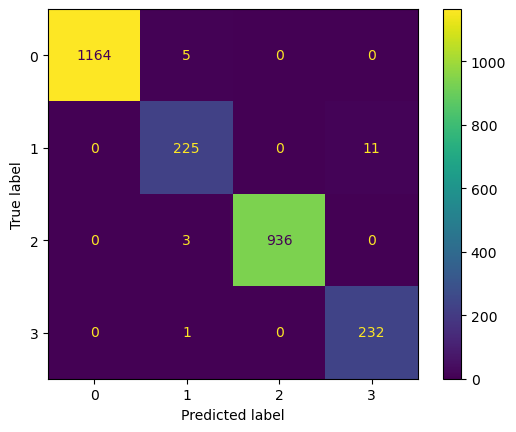

In [41]:
(_,accuracy) = model.evaluate(X_test, y_test)
accuracy = accuracy * 100.0
print(accuracy)

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

confusion_matrix = metrics.confusion_matrix(y_true_labels, y_pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


2215/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

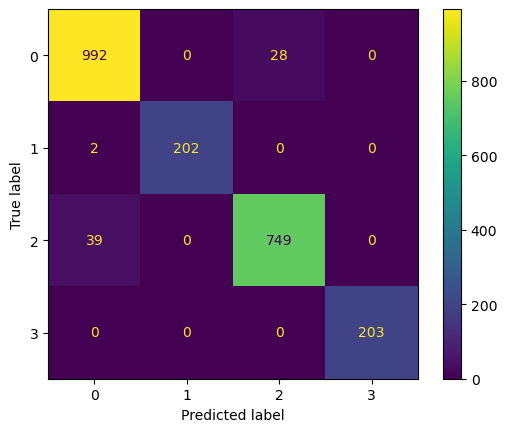

In [42]:
(_,accuracy) = model.evaluate(X_validate, y_validate)
accuracy = accuracy * 100.0
print(accuracy)

y_pred_ohe = model.predict(X_validate)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_validate, axis=1)

print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

confusion_matrix = metrics.confusion_matrix(y_true_labels, y_pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [43]:
keras_file = "linear.h5"
tf.keras.models.save_model(model, keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open("EssentialFeatures.tflite","wb").write(tfmodel)

2023-01-19 13:13:58.341225: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2023-01-19 13:13:58.341430: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-01-19 13:13:58.344559: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:716] Optimization results for grappler item: graph_to_optimize
2023-01-19 13:13:58.344571: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:718]   function_optimizer: function_optimizer did nothing. time = 0.005ms.
2023-01-19 13:13:58.344577: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:718]   function_optimizer: function_optimizer did nothing. time = 0.002ms.
2023-01-19 13:13:58.409428: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2023-01-19 13:13:58.409691: I tenso

1233808